<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/Autoencoder_YRBSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

In [3]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from pandas.api.types import is_numeric_dtype

## Load Dataset

In [10]:
dataset_url = "https://github.com/ipeirotis/autoencoders_census/raw/main/sadc_2017only_national_full.csv"
df = pd.read_csv(dataset_url)


In [11]:
df.head()

,sitecode,sitename,sitetype,sitetypenum,year,survyear,weight,stratum,PSU,record,...,qnwenthungry,qnmusclestrength,qnsunscreenuse,qnindoortanning,qnsunburn,qnconcentrating,qncurrentasthma,qnwheresleep,qnspeakenglish,qntransgender
0,XX,United States (XX),National,3,2017,14,2.4095,111,171190,1509749,...,NaN,1.0,NaN,2.0,1.0,1.0,NaN,NaN,1.0,NaN
1,XX,United States (XX),National,3,2017,14,1.6614,212,170890,1509750,...,NaN,1.0,NaN,2.0,2.0,1.0,NaN,NaN,1.0,NaN
2,XX,United States (XX),National,3,2017,14,0.7049,212,170890,1509751,...,NaN,2.0,NaN,2.0,2.0,2.0,NaN,NaN,1.0,NaN
3,XX,United States (XX),National,3,2017,14,0.7966,212,170890,1509752,...,NaN,1.0,NaN,2.0,1.0,2.0,NaN,NaN,1.0,NaN
4,XX,United States (XX),National,3,2017,14,1.9776,202,160270,1509753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
columns_to_drop = ['sitecode', 'sitename', 'sitetype', 'sitetypenum', 'year', 'survyear', 'record']
df = df.drop(columns = columns_to_drop, axis='columns')

## Code that transforms a dataframe to vector format and vice versa




In [ ]:
def transform_dataframe(df, variable_types):
    one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    min_max_scaler = MinMaxScaler()

    for column, variable_type in variable_types.items():
        if variable_type == 'categorical':
            df_encoded = pd.DataFrame(one_hot_encoder.fit_transform(df[[column]]))
            df_encoded.columns = [f"{column}_{cat}" for cat in one_hot_encoder.categories_[0]]
            df = pd.concat([df, df_encoded], axis=1)
            df = df.drop(column, axis=1)
        elif variable_type == 'numeric' and is_numeric_dtype(df[column]):
            df[column] = min_max_scaler.fit_transform(df[[column]])
    
    return df, one_hot_encoder, min_max_scaler


def reverse_transform_dataframe(df, variable_types, one_hot_encoder, min_max_scaler):
    for column, variable_type in variable_types.items():
        if variable_type == 'categorical':
            original_cols = [col for col in df.columns if col.startswith(f"{column}_")]
            df_original = pd.DataFrame(one_hot_encoder.inverse_transform(df[original_cols]))
            df_original.columns = [column]
            df = pd.concat([df, df_original], axis=1)
            df = df.drop(original_cols, axis=1)
        elif variable_type == 'numeric' and is_numeric_dtype(df[column]):
            df[column] = min_max_scaler.inverse_transform(df[[column]])

    return df


In [ ]:
# Example code that calls the functions above

# For converting "column1" as a categorical variable and "column2" as a numeric
variable_types = {'column1': 'categorical', 'column2': 'numeric'}
transformed_df, one_hot_encoder, min_max_scaler = transform_dataframe(df, variable_types)

# This code takes the vector representation and does the inverse transform
original_df = reverse_transform_dataframe(transformed_df, variable_types, one_hot_encoder, min_max_scaler)


In [ ]:
df1 = df.iloc[:, :100]
df1.head()

In [4]:
lst = [216, 232, 242, 245, 247, 249, 251, 252, 253, 256]
df1 = pd.concat([df1, df.iloc[:, lst]], axis=1)
df1.head()

,weight,stratum,PSU,age,sex,grade,race4,race7,stheight,stweight,...,qdrivemarijuana,qhallucdrug,qsportsdrink,qwater,qfoodallergy,qmusclestrength,qindoortanning,qsunburn,qconcentrating,qspeakenglish
0,2.4095,111,171190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0 times,0 times,1 to 3 times,4 to 6 times,Not sure,3 days,0 times,2 times,Yes,Very well
1,1.6614,212,170890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Did not drive,0 times,1 to 3 times,1 time per day,Not sure,4 days,0 times,0 times,Yes,Very well
2,0.7049,212,170890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2 or 3 times,0 times,1 to 3 times,1 to 3 times,No,1 day,0 times,0 times,No,Very well
3,0.7966,212,170890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4 or 5 times,3 to 9 times,Did not drink sports drink,4 or more times per day,No,3 days,0 times,1 time,No,Very well
4,1.9776,202,160270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Did not drive,0 times,1 to 3 times,4 to 6 times,No,NaN,NaN,NaN,NaN,NaN


In [5]:
dict1 = {
        'age': 'age',
        'sex': 'sex', 'grade':'grade','race4':'Hispanic or Latino','race7':'race',
       'qnobese':'obese','qnowt':'overweight','q67':'sexual identity','q66':'sex/sexual contacts',
       'sexid':'sexid','sexid2':'sexid2','sexpart':'sexpart','sexpart2':'sexpart2','q8':'seat belt use','q9':'riding with a drinking driver',
       'q10':'drinking and driving','q11':'texting and driving','q12':'weapon carrying','q13':'weapon carrying at school',
       'q14':'gun carrying past 12 mos','q15':'safety concerns at school','q16':'threatened at school','q17':'physical fighting',
       'q18':'physical fighting at school','q19':'forced sexual intercourse','q20':'sexual violence','q21':'sexual dating violence',
       'q22':'physical dating violence','q23':'bullying at school','q24':'electronic bullying','q25':'sad or hopeless',
       'q26':'considered suicide','q27':'made a suicide plan','q28':'attempted suicide','q29':'injurious suicide attempt',
       'q30':'ever cigarette use','q31':'initation of cigarette smoking','q32':'current cigarette use','q33':'smoking amounts per day',
       'q34':'electronic vapor product use','q35':'current electronic vapor product use','q36':'EVP from store','q37':'current smokeless tobacco use',
       'q38':'current cigar use','q39':'all tobacco product cessation','q40':'ever alcohol use','q41':'initiation of alcohol use',
       'q42':'current alcohol use','q43':'source of alcohol','q44':'current binge drinking','q45':'largest number of drinks',
       'q46':'ever marijuana use','q47':'initiation of marijuana use','q48':'current marijuana use','q49':'ever cocaine use',
       'q50':'ever inhalant use','q51':'ever heroin use','q52':'ever methamphetamine use','q53':'ever ecstasy use',
       'q54':'ever synthetic marijuana use','q55':'ever steroid use','q56':'ever prescription pain medicine use','q57':'illegal injected drug use',
       'q58':'illegal drugs at school','q59':'ever sexual intercourse','q60':'first sex intercourse','q61':'multiple sex partners',
       'q62':'current sexual activity','q63':'alcohol/drugs at sex','q64':'condom use','q65':'birth control pill use',
       'q68':'perception of weight','q69':'weight loss','q70':'fruit juice drinking','q71':'fruit eating','q72':'green salad eating',
       'q73':'potato eating','q74':'carrot eating','q75':'other vegetable eating','q76':'soda drinking','q77':'milk drinking',
       'q78':'breakfast eating','q79':'physical activity','q80':'television watching','q81':'computer not school work use',
        'q82':'PE attendance','q83':'sports team participation','q84':'concussion in last 12 mos','q85':'HIV testing','q86':'oral health care',
       'q87':'asthma','q88':'sleep on school night','q89':'grades in school', 'qdrivemarijuana':'drive when using marijuana',
       'qhallucdrug':'ever used LSD', 'qsportsdrink':'sports drinks','qwater':'plain water','qfoodallergy':'food allergies',
        'qmusclestrength':'muscle stregthening','qindoortanning':'indoor tanning','qsunburn':'sunburn','qconcentrating':'difficulty concentrating',
        'qspeakenglish':'how well speak English'}

In [6]:
df1.rename(columns=dict1, inplace = True)

In [7]:
df1.isnull().sum()

weight                         0
stratum                        0
PSU                            0
age                           81
sex                          127
                            ... 
muscle stregthening         4052
indoor tanning              1751
sunburn                     4056
difficulty concentrating    4097
how well speak English      4054
Length: 110, dtype: int64

In [ ]:
missing_percentages = df1.isnull().mean() * 100
columns_with_missing_gt_25 = missing_percentages[missing_percentages > 25].index

# Select the columns with missing values > 25%
selected_columns = df1[columns_with_missing_gt_25]

# Print the selected columns
print(selected_columns)

In [ ]:
# Iterate over each variable in the dataframe
for column in selected_columns:
  # create a new column name by appending
  missing_dummy_column = f'{column}_missing_dummy'
  df1[missing_dummy_column] = df1[column].isnull().astype(int)

# Display the updated dataframe
df1.head()

In [10]:
data_num = df1[["weight","stratum","PSU","stheight","stweight","bmi","bmipct","obese","overweight"]]

In [11]:
data_cat = df1.copy()
data_cat = data_cat.drop(data_num.columns, axis = 1)
data_cat.head()

,age,sex,grade,Hispanic or Latino,race,sexual identity,sex/sexual contacts,sexid,sexid2,sexpart,...,source of alcohol_missing_dummy,largest number of drinks_missing_dummy,ever used LSD_missing_dummy,sports drinks_missing_dummy,plain water_missing_dummy,food allergies_missing_dummy,muscle stregthening_missing_dummy,sunburn_missing_dummy,difficulty concentrating_missing_dummy,how well speak English_missing_dummy
0,NaN,NaN,NaN,NaN,NaN,Heterosexual (straight),Females,Heterosexual,Heterosexual,NaN,...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,NaN,NaN,NaN,Bisexual,Never had sexual contact,Bisexual,Sexual Minority,NaN,...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,NaN,NaN,NaN,Heterosexual (straight),Males,Heterosexual,Heterosexual,NaN,...,1,1,0,0,0,0,0,0,0,0
3,NaN,NaN,NaN,NaN,NaN,Heterosexual (straight),Females,Heterosexual,Heterosexual,NaN,...,0,0,0,0,0,0,0,0,0,0
4,NaN,NaN,NaN,NaN,NaN,Heterosexual (straight),Never had sexual contact,Heterosexual,Heterosexual,NaN,...,0,0,0,0,0,0,1,1,1,1


In [12]:
#scale on numerical columns--brings the value of each feature into the range of 0 to 1
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
def scaleNum(df_num, cols):
    for col in cols:
        df_num[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(data_num[col])),columns=[col])
    return df_num
data_normal_num = scaleNum(data_num,data_num.columns)

<ipython-input-12-5a488c6b30b6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(data_num[col])),columns=[col])
<ipython-input-12-5a488c6b30b6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(data_num[col])),columns=[col])
<ipython-input-12-5a488c6b30b6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [13]:
data_normal_num.head()

,weight,stratum,PSU,stheight,stweight,bmi,bmipct,obese,overweight
0,0.508875,0.088496,0.296542,NaN,NaN,NaN,NaN,NaN,NaN
1,0.347927,0.982301,0.295986,NaN,NaN,NaN,NaN,NaN,NaN
2,0.142144,0.982301,0.295986,NaN,NaN,NaN,NaN,NaN,NaN
3,0.161873,0.982301,0.295986,NaN,NaN,NaN,NaN,NaN,NaN
4,0.415955,0.893805,0.276306,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# onehot_encoder on categorical columns
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
def scaleCat(df_cat, cols):
    for col in cols:
        df_cat[col] = pd.DataFrame(onehot_encoder.fit_transform(pd.DataFrame(data_cat[col])),columns=[col])
    return df_cat
data_normal_cat = scaleCat(data_cat,data_cat.columns)

In [41]:
data_normal_cat.head()

,age,sex,grade,Hispanic or Latino,race,sexual identity,sex/sexual contacts,sexid,sexid2,sexpart,...,source of alcohol_missing_dummy,largest number of drinks_missing_dummy,ever used LSD_missing_dummy,sports drinks_missing_dummy,plain water_missing_dummy,food allergies_missing_dummy,muscle stregthening_missing_dummy,sunburn_missing_dummy,difficulty concentrating_missing_dummy,how well speak English_missing_dummy
0,"(0, 7)\t1.0","(0, 2)\t1.0","(0, 4)\t1.0","(0, 4)\t1.0","(0, 7)\t1.0","(0, 2)\t1.0","(0, 0)\t1.0","(0, 2)\t1.0","(0, 0)\t1.0","(0, 4)\t1.0",...,"(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0"
1,"(0, 7)\t1.0","(0, 2)\t1.0","(0, 4)\t1.0","(0, 4)\t1.0","(0, 7)\t1.0","(0, 0)\t1.0","(0, 3)\t1.0","(0, 0)\t1.0","(0, 1)\t1.0","(0, 4)\t1.0",...,"(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0"
2,"(0, 7)\t1.0","(0, 2)\t1.0","(0, 4)\t1.0","(0, 4)\t1.0","(0, 7)\t1.0","(0, 2)\t1.0","(0, 2)\t1.0","(0, 2)\t1.0","(0, 0)\t1.0","(0, 4)\t1.0",...,"(0, 1)\t1.0","(0, 1)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0"
3,"(0, 7)\t1.0","(0, 2)\t1.0","(0, 4)\t1.0","(0, 4)\t1.0","(0, 7)\t1.0","(0, 2)\t1.0","(0, 0)\t1.0","(0, 2)\t1.0","(0, 0)\t1.0","(0, 4)\t1.0",...,"(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0"
4,"(0, 7)\t1.0","(0, 2)\t1.0","(0, 4)\t1.0","(0, 4)\t1.0","(0, 7)\t1.0","(0, 2)\t1.0","(0, 3)\t1.0","(0, 2)\t1.0","(0, 0)\t1.0","(0, 4)\t1.0",...,"(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 0)\t1.0","(0, 1)\t1.0","(0, 1)\t1.0","(0, 1)\t1.0","(0, 1)\t1.0"


In [16]:
# merge numerical columns and categorical columns based on their indices
data = data_normal_num.merge(data_normal_cat, left_index = True, right_index = True)

In [17]:
data.shape

(14765, 123)

In [18]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K


# the dimensionality of a latent space in an autoencoder
latent_dimension = 1
batch_size = 20
# the number of nuerons in a hidden layer
hidden_nodes = 16

# create the input layer for the encoder
input_encoder = Input(shape=(123,), name="Input_Encoder")
# apply batch normalization to the encoder input layer
batch_normalize1 = BatchNormalization()(input_encoder)
# create a hidden layer in the encoder
hidden_layer = Dense(hidden_nodes, activation="relu", name="Hidden_Encoding")(
    batch_normalize1
)
batch_normalize2 = BatchNormalization()(hidden_layer)
# create the output layer of the encoder
z = Dense(latent_dimension, name="Mean")(batch_normalize2)

In [19]:
from keras import Model


encoder = Model(input_encoder, z)

In [20]:
# create an input layer of the decoder
input_decoder = Input(shape=(latent_dimension,), name="Input_Decoder")
batch_normalize1 = BatchNormalization()(input_decoder)
# create a hidden layer
decoder_hidden_layer = Dense(hidden_nodes, activation="relu", name="Hidden_Decoding")(
    batch_normalize1
)
batch_normalize2 = BatchNormalization()(decoder_hidden_layer)
# create the output layer of the autoencoder
decoded = Dense(123, activation="linear", name="Decoded")(batch_normalize2)

In [21]:
# specify the input and output layer of the decoder
decoder = Model(input_decoder, decoded, name="Decoder")

In [22]:
# create a complete autoencoder architecture
encoder_decoder = decoder(encoder(input_encoder))

ae = Model(input_encoder, encoder_decoder)
# a summary of the autoencoder model
ae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Encoder (InputLayer)  [(None, 123)]             0         
                                                                 
 model (Functional)          (None, 1)                 2557      
                                                                 
 Decoder (Functional)        (None, 123)               2191      
                                                                 
Total params: 4,748
Trainable params: 4,436
Non-trainable params: 312
_________________________________________________________________


In [23]:
data.fillna(-1, inplace=True)

In [27]:
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# set the seed for random number generation
set_seed(2021)
# compile the complete autoencoder model
ae.compile(loss="mean_squared_error", optimizer="adam")

# use checkpoint during model training
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0)

# train the autoencoder model on the input data
history = ae.fit(
    data, data, shuffle=True, epochs=10, batch_size=20, validation_split=0.2, verbose=0
).history

In [26]:
from tensorflow.keras.models import load_model

ae = load_model('model.h5')

OSError: ignored

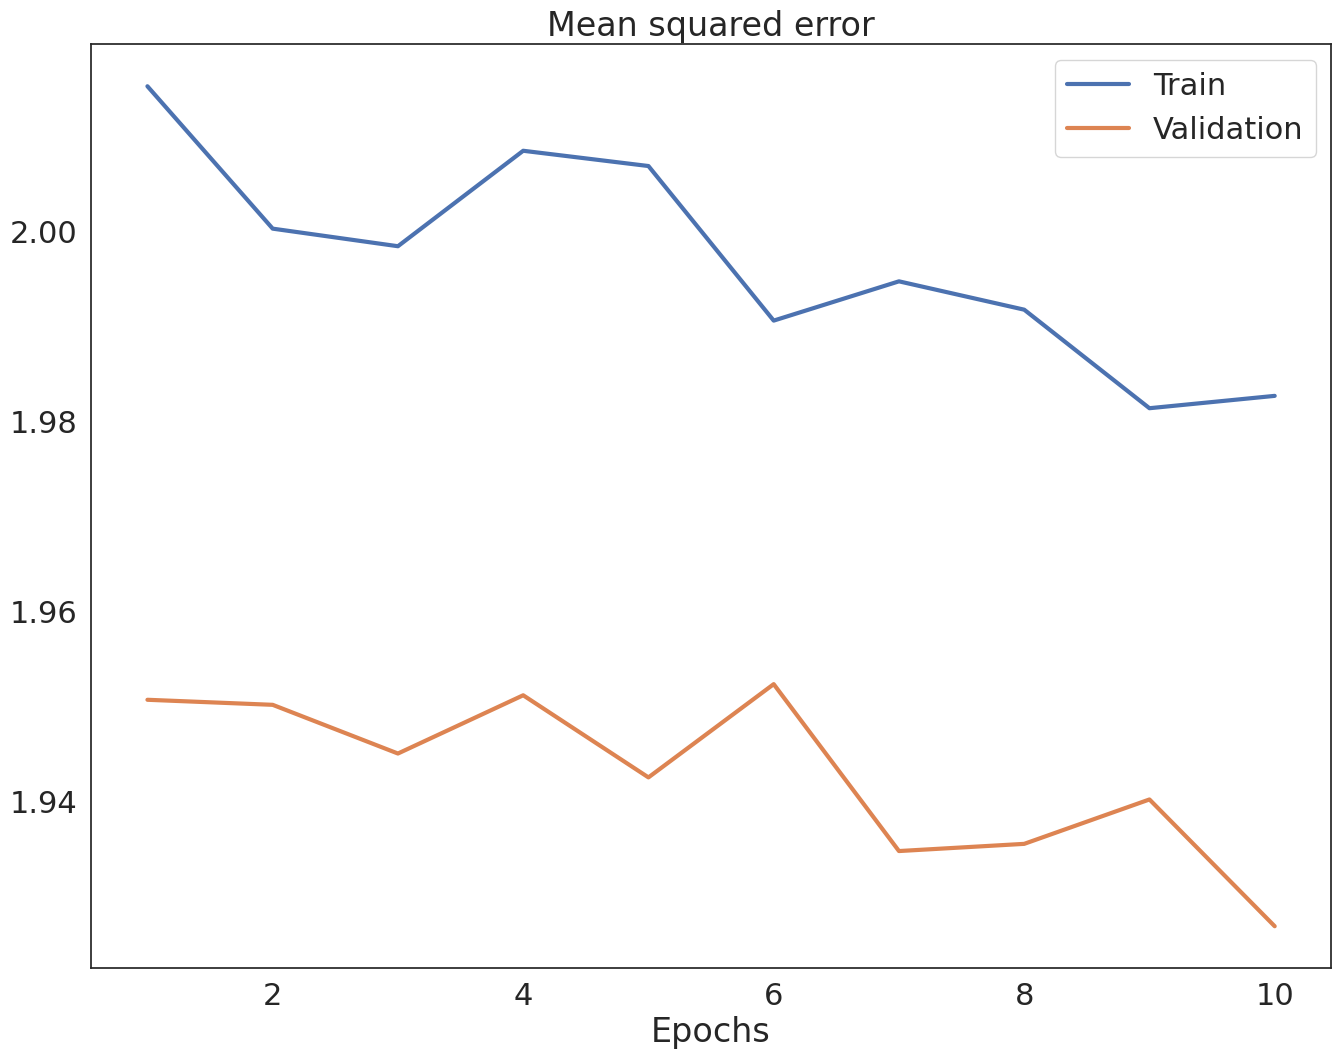

Training MSE = 1.4080845204853452
Validation MSE = 1.3881128315261282


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(font_scale=2)
sns.set_style("white")


def model_analysis(history):
    # extract the training loss and validation loss values from the history object
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    # x-axis values for the plot
    t = np.linspace(1, len(train_loss), len(train_loss))

    plt.figure(figsize=(16, 12))
    plt.title("Mean squared error")
    # plot the training loss and validation loss against the epoch values on the x-axis
    sns.lineplot(x=t, y=train_loss, label="Train", linewidth=3)
    sns.lineplot(x=t, y=val_loss, label="Validation", linewidth=3)
    plt.xlabel("Epochs")

    plt.legend()
    plt.savefig("FirstNet.png", dpi=400)
    plt.show()
    # the square root of the final training loss and validation loss values
    print(f"Training MSE = {np.sqrt(train_loss[-1])}")
    print(f"Validation MSE = {np.sqrt(val_loss[-1])}")


model_analysis(history)

462/462 [==============================] - 1s 1ms/step


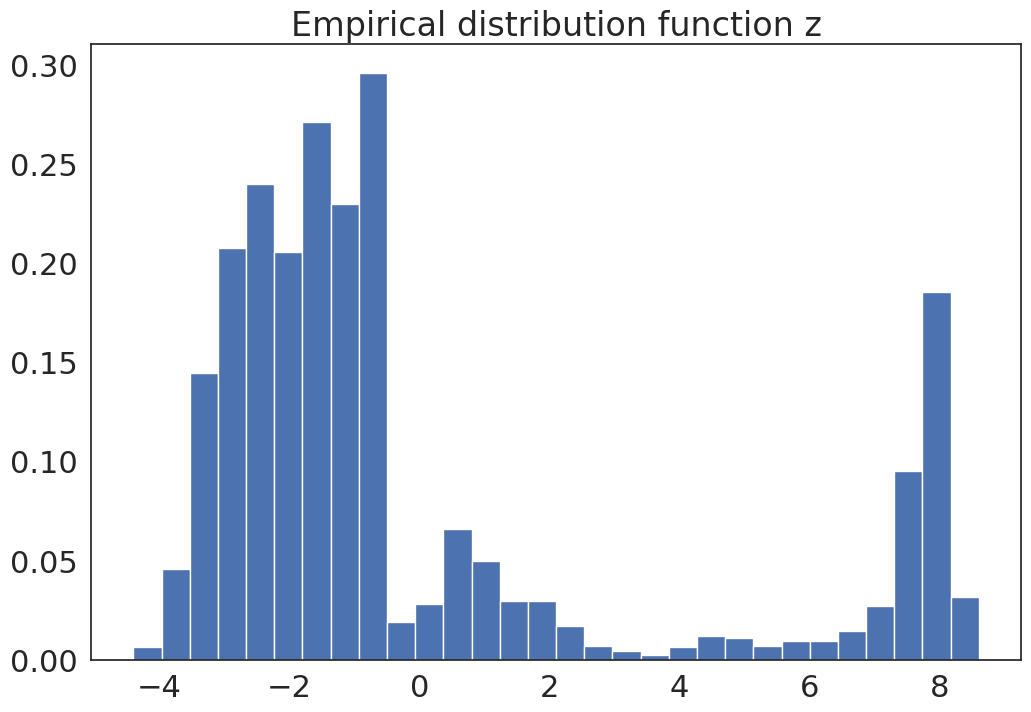

In [30]:
plt.figure(figsize=(12, 8))
plt.title("Empirical distribution function z")
plt.xticks((-8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14))
# use the encoder model to obtain the latent representation (z) of the data input
plt.hist(encoder.predict(data), bins=30, density=True)
plt.savefig("DistInternal.png", dpi=400)

In [31]:
ae.predict(data)[0,:]

462/462 [==============================] - 1s 1ms/step


array([ 0.2687069 ,  0.46945122,  0.53207034,  0.38273144,  0.14461367,
        0.00733005,  0.45154583,  0.6594226 ,  0.6018154 ,  4.227808  ,
        0.68057877,  1.3204775 ,  2.1413403 ,  4.352363  ,  1.8434035 ,
        1.0949422 ,  1.8370647 ,  0.10321388,  1.8368707 ,  1.0386981 ,
        1.1459827 ,  0.49319324,  0.8787838 ,  2.081946  ,  0.85198385,
        0.19402179,  0.22864842,  0.3010638 ,  0.238457  ,  1.385504  ,
        0.27579457,  0.09206224,  0.41766503,  0.66064423,  0.50001514,
        0.19590774,  0.24544549,  0.3938366 ,  0.21539988,  0.20648515,
        1.0150988 ,  0.68407494,  0.5982945 ,  3.8423333 ,  0.7768038 ,
        3.936083  ,  0.695113  ,  2.4149904 ,  4.219656  ,  0.48265553,
        0.61655635,  1.2762188 ,  3.3683836 ,  2.5654259 ,  2.7102365 ,
        5.20129   ,  1.6013086 ,  5.299888  ,  2.3412495 ,  3.0731318 ,
        1.1412528 ,  0.2148099 ,  0.19904456, -0.02814259,  0.01933879,
        0.0512156 ,  0.20951971,  0.16984527,  0.51621145, -0.04

462/462 [==============================] - 1s 1ms/step


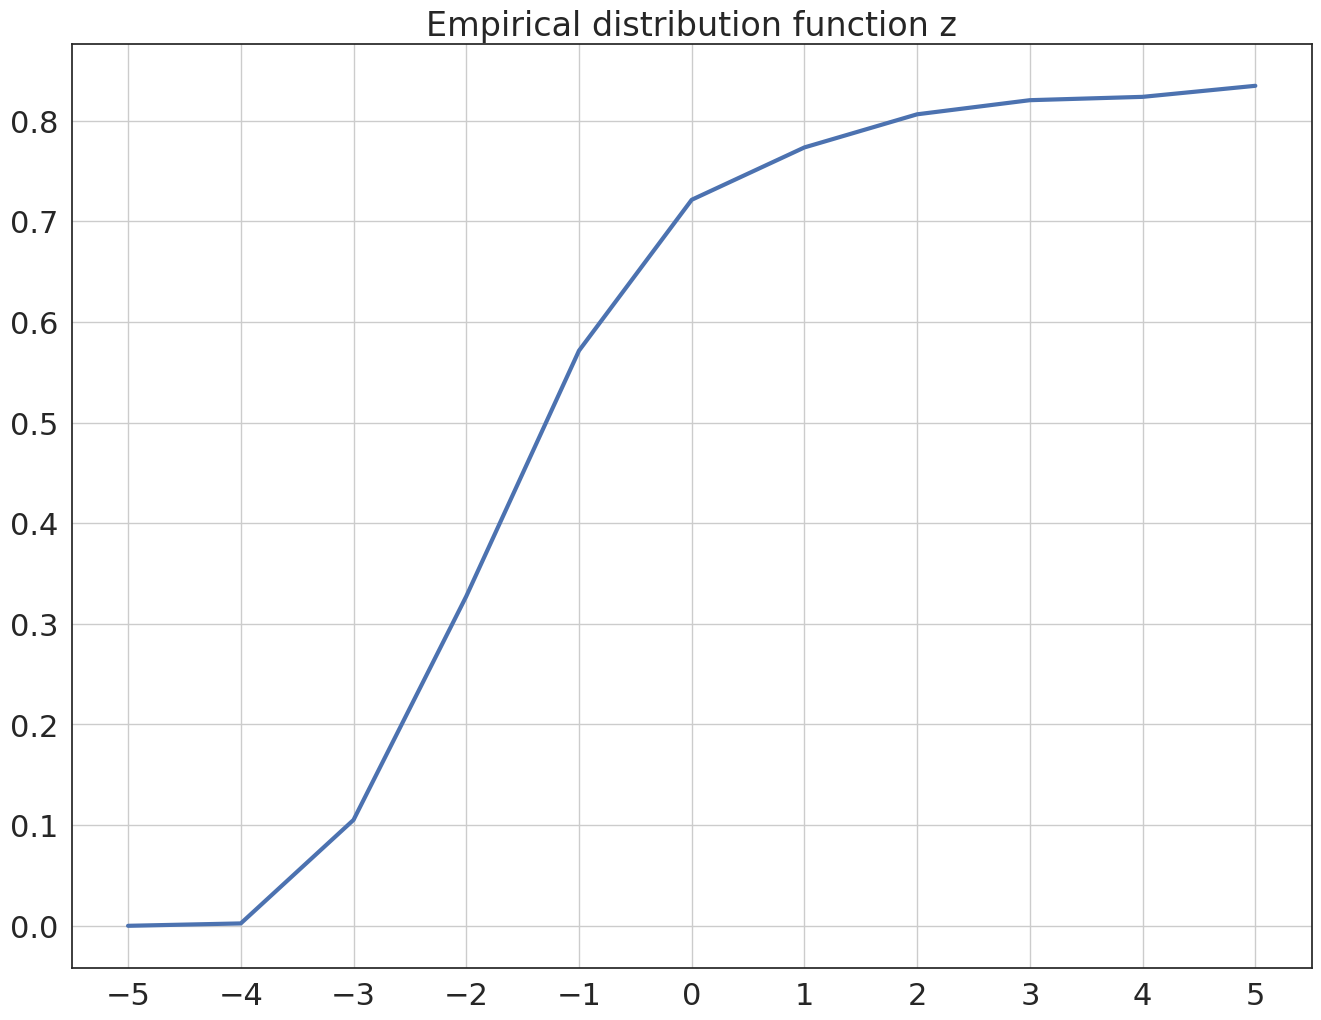

In [32]:
# plot the empirical distribution function for the values obtained from the encoder's predictions on the dataset
from statsmodels.distributions.empirical_distribution import ECDF


ecdf = ECDF(encoder.predict(data)[:, 0])
plt.figure(figsize=(16, 12))
plt.title("Empirical distribution function z")
x = (-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5)
plt.yticks(np.linspace(0, 1, 11))
plt.xticks(x)
plt.grid()
plt.plot(x, ecdf(x), linewidth=3)
plt.savefig("EmpiricalDF.png", dpi=400)

In [33]:
from scipy.interpolate import interp1d


x = (-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5)
# calculate the sample EDF values at the specified x-values
sample_edf_values_at_slope_changes = [ecdf(i) for i in x]
inverted_edf = interp1d(sample_edf_values_at_slope_changes, x)

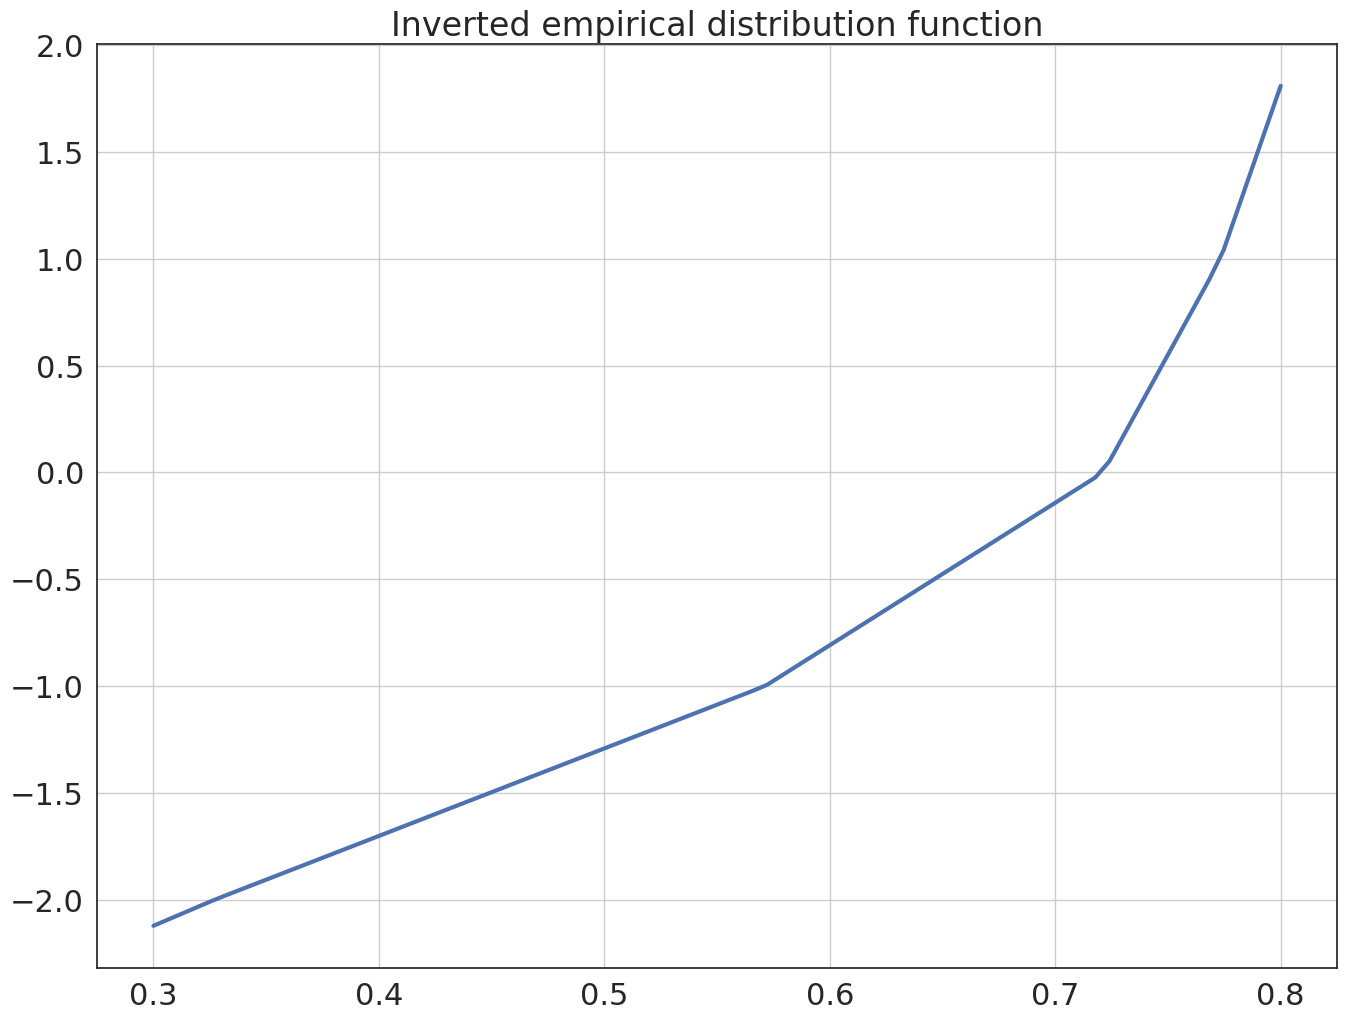

In [34]:
from numpy.random import uniform
from numpy.random import seed

# number of data points to generate
N = 10000
seed(2021)
plt.figure(figsize=(16, 12))
plt.title("Inverted empirical distribution function")
x = np.linspace(0.30, 0.80, 80)
plt.xticks(np.linspace(0, 1.0, 11))
plt.grid()
plt.plot(x, inverted_edf(x), linewidth=3)
plt.savefig("InvertedEmpiricalDF.png", dpi=400)

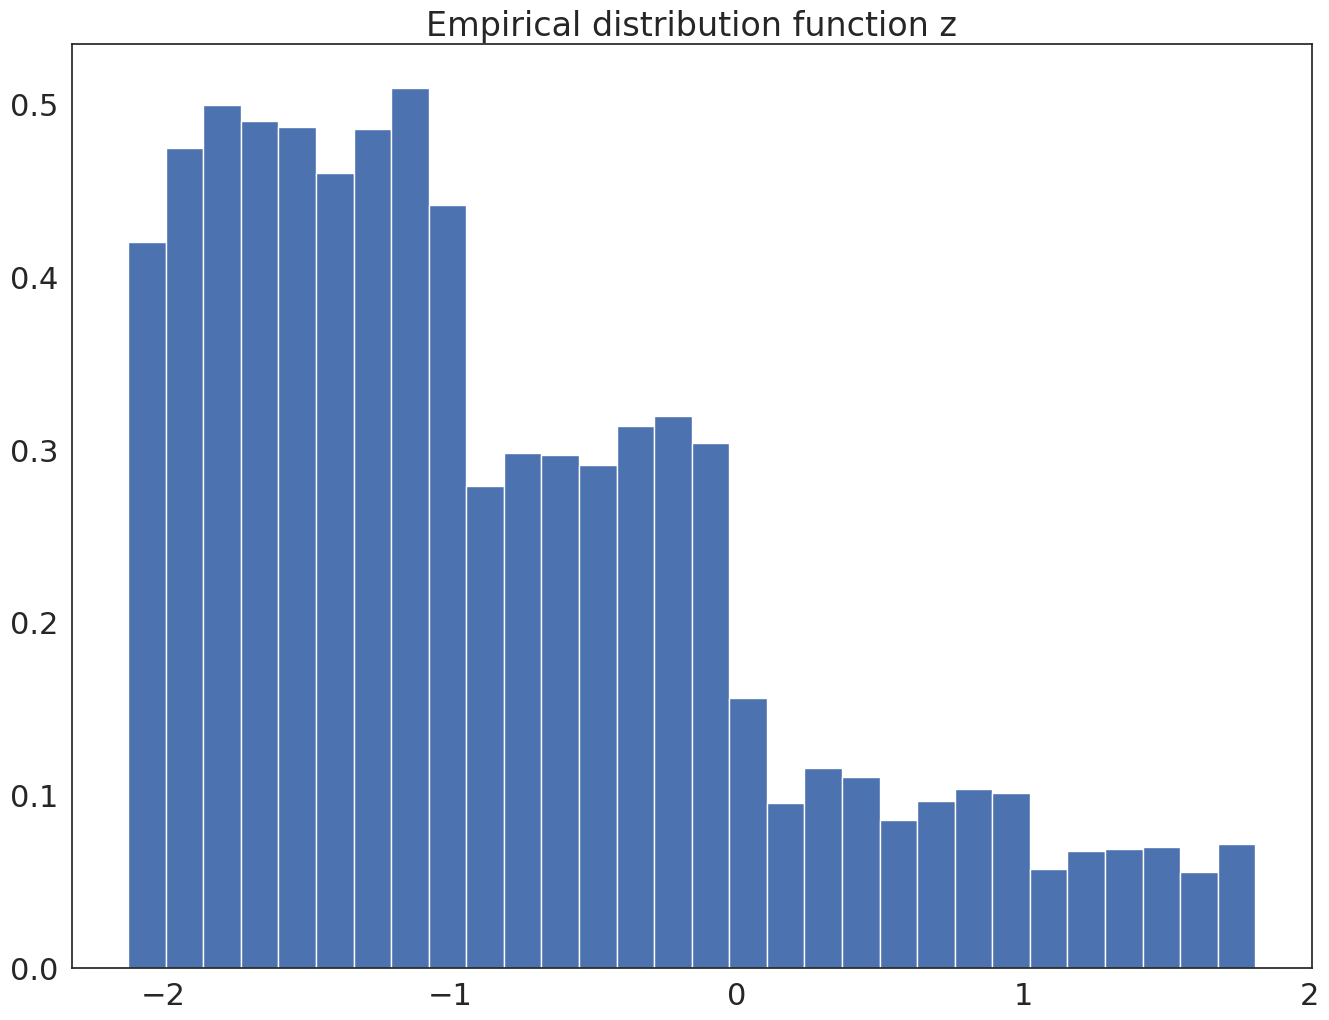

In [35]:
# number of data points to generate
N = 10000
seed(2021)
plt.figure(figsize=(16, 12))
plt.title("Empirical distribution function z")
plt.xticks((-5, -4, -3, -2, -1, 0, 1, 2, 3, 4))
# N random values from a uniform distribution are transformed to follow a specific distribution using the inverted EDF
plt.hist(inverted_edf(uniform(0.30, 0.80, N)), bins=30, density=True)
plt.savefig("DistGenerated.png", dpi=400)

462/462 [==============================] - 1s 1ms/step


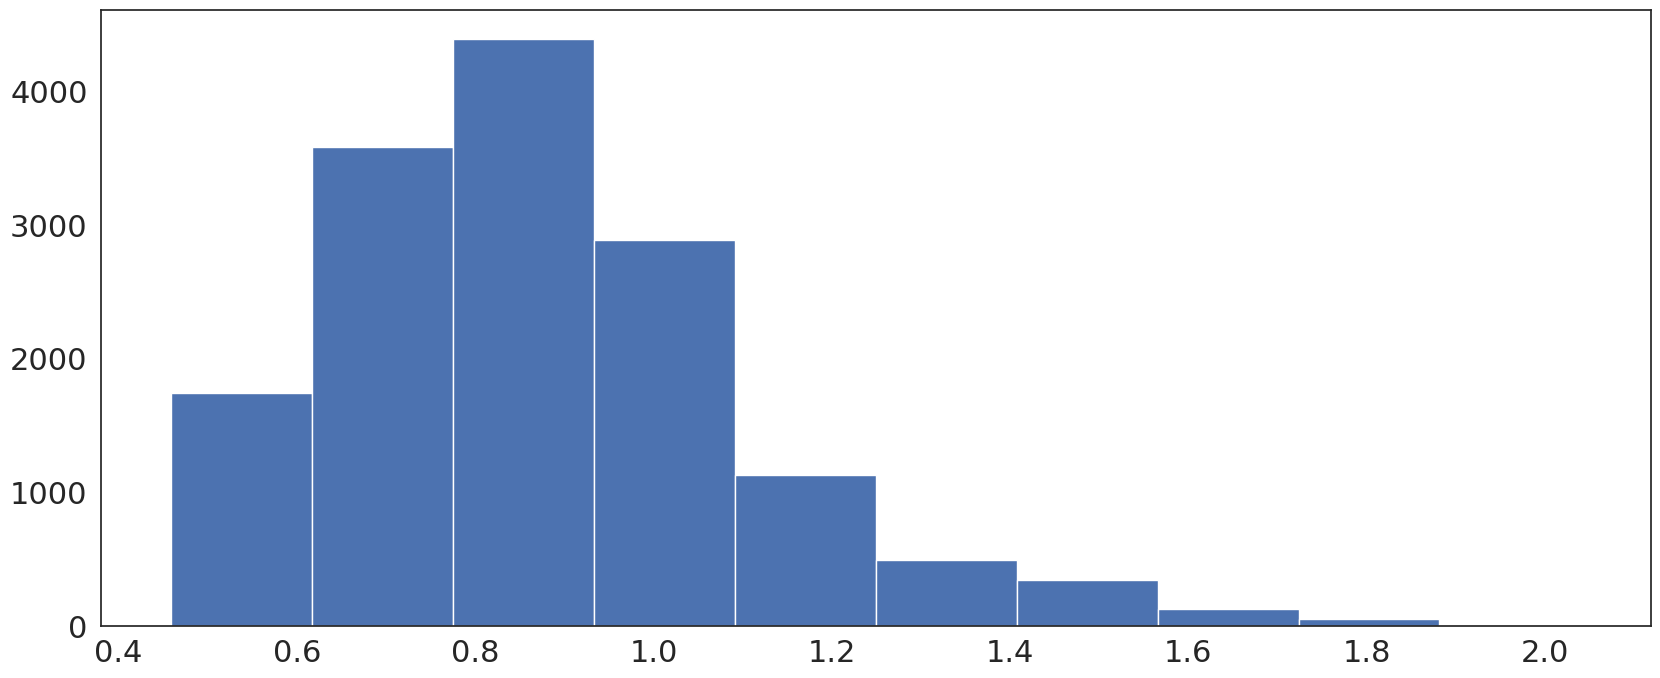

In [36]:
import tensorflow as tf

plt.figure(figsize=(20, 8))
# reconstruct the original data
normal_reconstructions = ae.predict(data)
# compute the Mean Absolute Error between the reconstructed data and the original data
normal_loss = tf.losses.mae(normal_reconstructions, data)
plt.hist(normal_loss, bins=10)
plt.show()

In [37]:
threshold = np.mean(normal_loss) + 2*np.std(normal_loss)
print(threshold)

1.3392946932561585


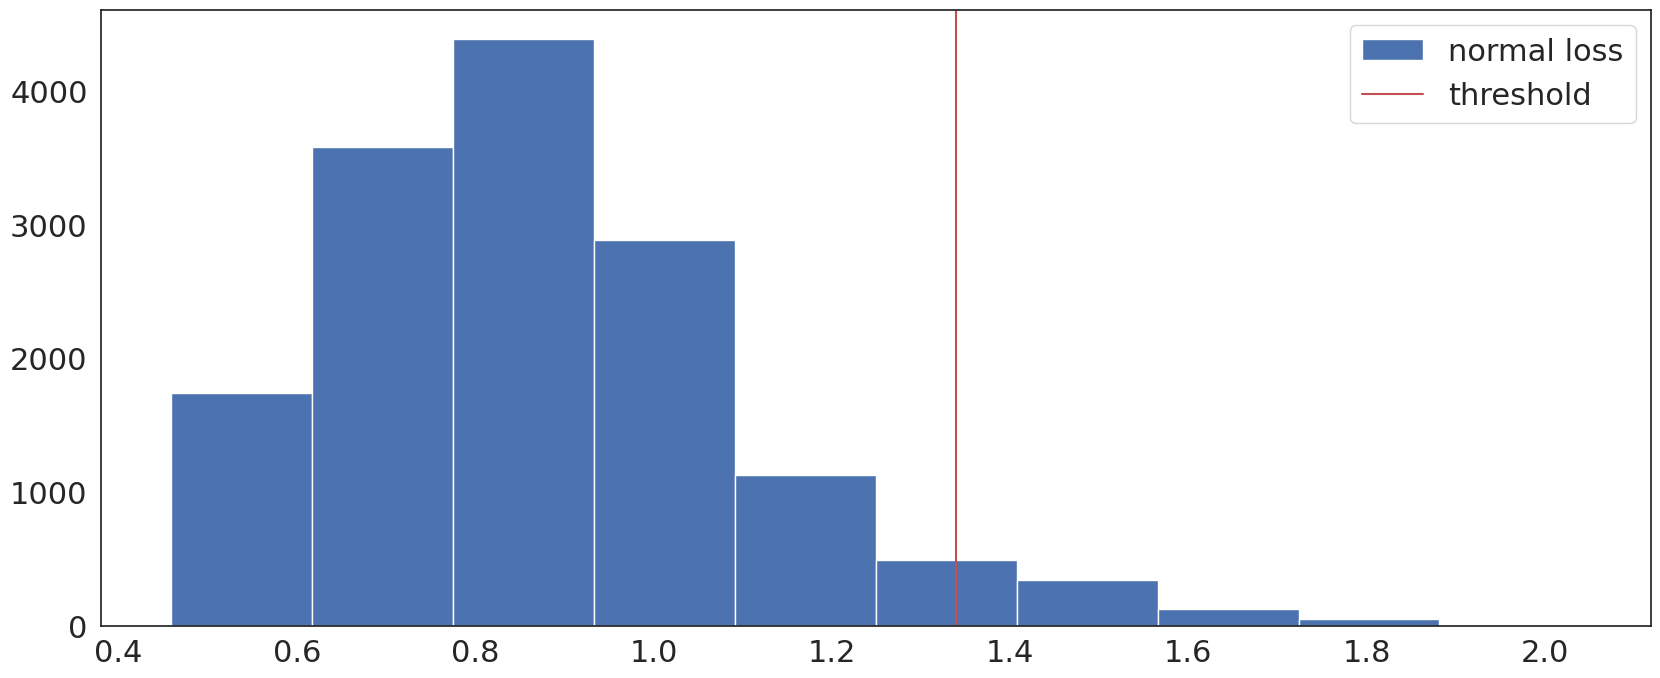

In [38]:
plt.figure(figsize=(20, 8))
plt.hist(normal_loss, bins=10, color='b', label="normal loss")
# add a vertical line to the plot at the position of the threshold value
plt.axvline(threshold, color='r', label="threshold")
plt.legend()
plt.show()

In [39]:
# Get the indices that would sort the mae array in descending order
sorted_indices = np.argsort(normal_loss)[::-1]

In [ ]:
k = 100  # Number of samples to select
samples_with_high_error = data.iloc[sorted_indices[:k]]
samples_with_high_error.head()

In [ ]:
# Find indices of tuples with reconstruction values larger than the threshold
anomaly_indices = np.where(normal_loss > threshold)[0]

# Select the corresponding tuples from the original data
anomaly_tuples = data.iloc[anomaly_indices]

# Print the anomaly tuples
anomaly_tuples.head()


In [ ]:
anomaly_tuples.shape